# Model Evaluation
This notebook contains steps for evaluating models to predict the percentage increase in Queens.  
The step I'll take it as below ...
1. Compare the total RMSE (sum of all 5 zipcodes) based on rolling forecast between models
2. Using the best model, forecast for the future terms
3. Find the zipcode with the most increase

In [109]:
%reload_ext autoreload
%autoreload 2

In [173]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import seaborn as sns

import pickle

from SCRIPT.eval_tools import *

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [111]:
with open('PKL/timeseries_queens_p.pkl', 'rb') as fp:
    df = pickle.load(fp)

In [112]:
df.index = pd.DatetimeIndex(df.index.values, freq='infer')

In [113]:
df.columns = df.columns.astype(str)

In [114]:
trdf = df.iloc[:int(len(df)*.8)]

In [115]:
tedf = df.iloc[int(len(df)*.8):]

For the initial univariate modeling, I will compare the top 5 zipcodes with the highest deviation from the average and one zipcode closest to the average.

In [116]:
select_zipcode = ['11101', '11693', '11692', '11694', '11103']

I'll run each model for each of the zipcodes. Then take the sum of squares across all predictions of all 5 zipcodes to compare between models.

# 1. SARIMA 
Our model has a seasonality and controllable stationarity. 

### zipcode [0]
---

In [117]:
zip_ = select_zipcode[0]

In [118]:
sel_df = trdf[zip_]

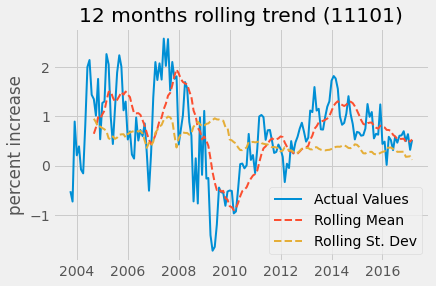

In [12]:
plot_moving_avg(sel_df, 12, zip_)

In [13]:
run_dickyey_fuller(sel_df, zip_)

Null Rejected (p = 0.0396). 11101 time series is stationary


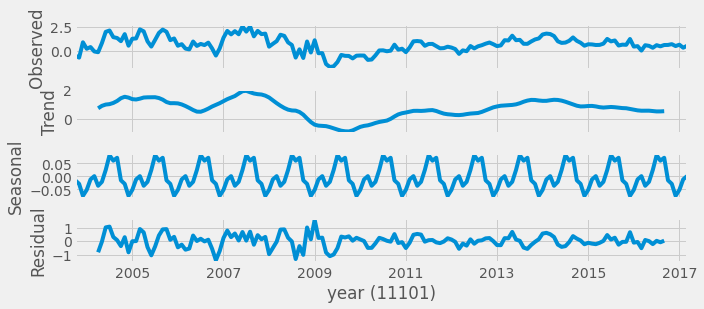

In [14]:
plot_decomposition(sel_df, zip_)

Time series is stationary but shows seasonality.

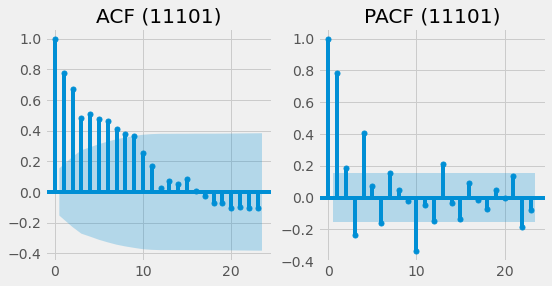

In [15]:
def_acf_pacf(sel_df, zip_)

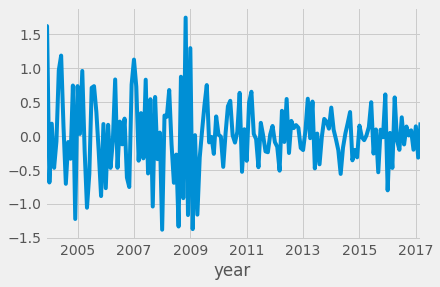

In [16]:
plot_basic(sel_df.diff(1)[1:])

In [17]:
run_dickyey_fuller(sel_df.diff(1)[1:], zip_)

Null Rejected (p = 0.0044). 11101 time series is stationary


#### SARIMA
First let's find the best parameters that yield the lowest AIC.

In [18]:
pdq, SPDQ = find_sarima_param(sel_df)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq: (1, 1, 1), PDQS: (0, 0, 1, 12) - AIC: 131.16


In [19]:
sarima = SARIMAX(sel_df, order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
model = sarima.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              11101   No. Observations:                  162
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                 -61.579
Date:                            Tue, 06 Oct 2020   AIC                            131.159
Time:                                    22:05:47   BIC                            143.121
Sample:                                10-01-2003   HQIC                           136.019
                                     - 03-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8314      0.066    -12.566      0.000      -0.961      -0.702
ma.L1          1.6267      0.259   

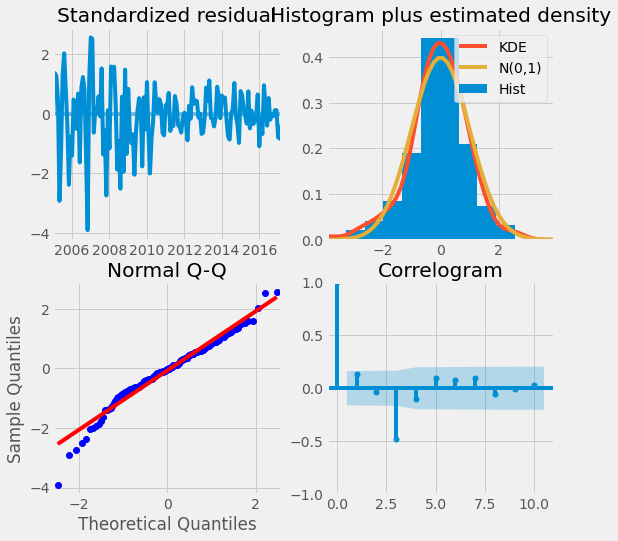

In [20]:
model.plot_diagnostics(figsize = (8, 8))
plt.show()

In [21]:
zip_

'11101'

For testing, we will calculate rmse based on rolling forecast.

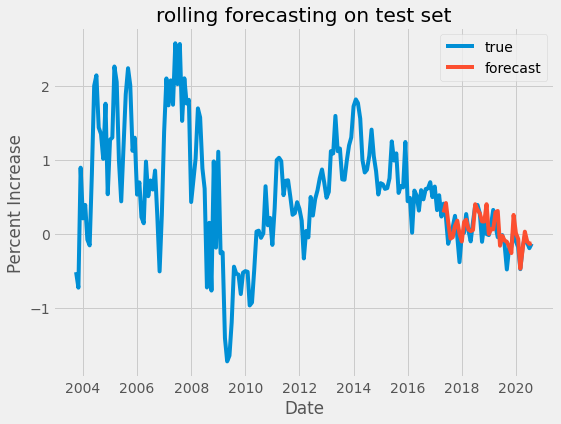

In [23]:
rmse_11101 = test_RMSE(df[zip_], pdq, SPDQ)

### zipcode [1]
---

In [24]:
zip_ = select_zipcode[1]

In [25]:
sel_df = trdf[zip_]

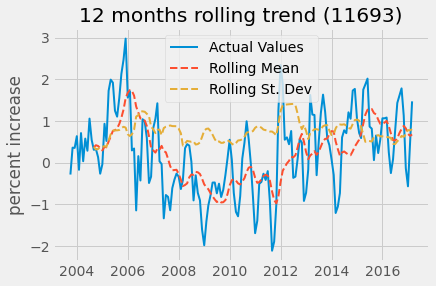

In [26]:
plot_moving_avg(sel_df, 12, zip_)

In [27]:
run_dickyey_fuller(sel_df, zip_)

Failed to reject the null (p = 0.515). 11693 time series is not stationary


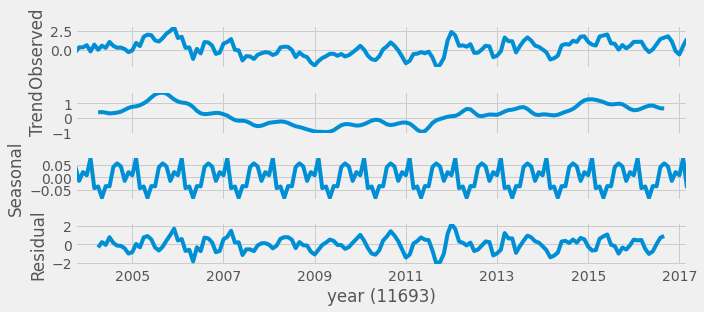

In [28]:
plot_decomposition(sel_df, zip_)

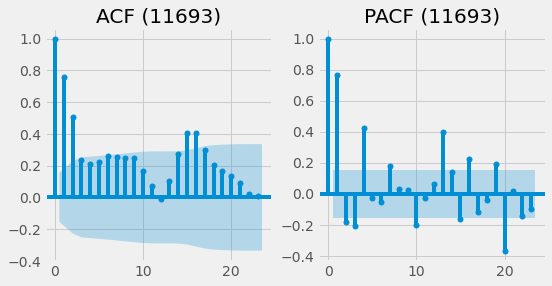

In [29]:
def_acf_pacf(sel_df, zip_)

Removing trend by differencing

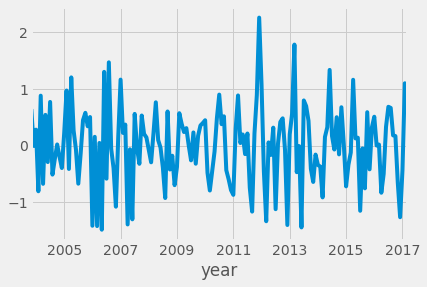

In [30]:
plot_basic(sel_df.diff(1)[1:])

In [31]:
run_dickyey_fuller(sel_df.diff(1)[1:], zip_)

Null Rejected (p = 0.0). 11693 time series is stationary


#### SARIMA
First let's find the best parameters that yield the lowest AIC.

In [32]:
pdq, SPDQ = find_sarima_param(sel_df)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq: (1, 1, 1), PDQS: (1, 0, 1, 12) - AIC: 226.11


In [33]:
sarima = SARIMAX(sel_df, order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
model = sarima.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              11693   No. Observations:                  162
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -108.056
Date:                            Tue, 06 Oct 2020   AIC                            226.113
Time:                                    22:07:17   BIC                            241.065
Sample:                                10-01-2003   HQIC                           232.188
                                     - 03-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9246      0.042    -22.181      0.000      -1.006      -0.843
ma.L1          1.1841      0.110   

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


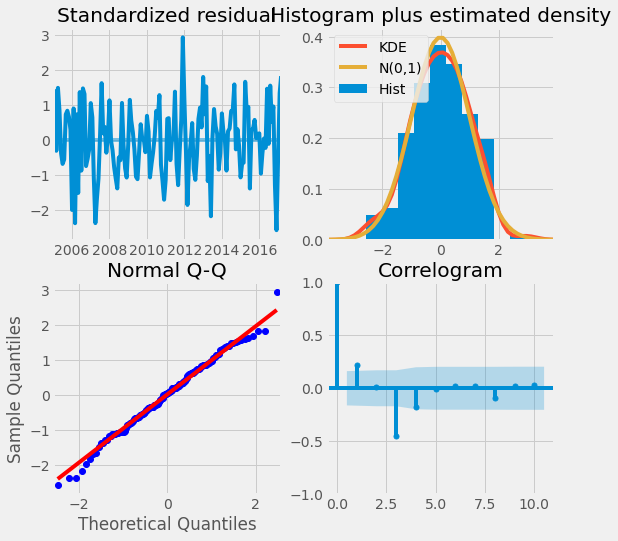

In [34]:
model.plot_diagnostics(figsize = (8, 8))
plt.show()

In [35]:
zip_

'11693'

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

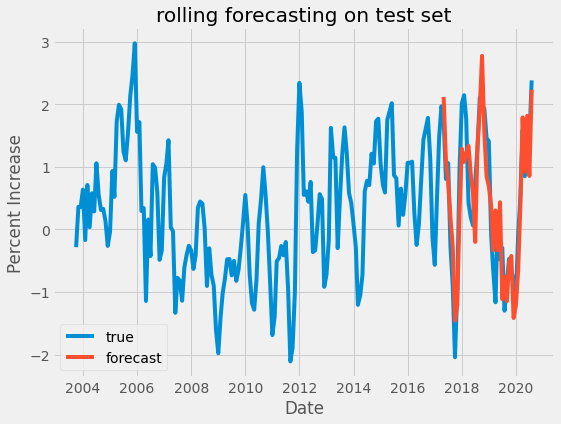

In [36]:
rmse_11693 = test_RMSE(df[zip_], pdq, SPDQ)

### zipcode [2]
---

In [37]:
zip_ = select_zipcode[2]

In [38]:
sel_df = trdf[zip_]

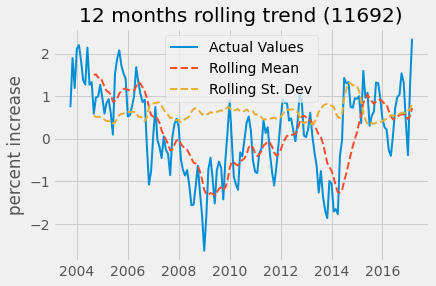

In [39]:
plot_moving_avg(sel_df, 12, zip_)

In [40]:
run_dickyey_fuller(sel_df, zip_)

Failed to reject the null (p = 0.2646). 11692 time series is not stationary


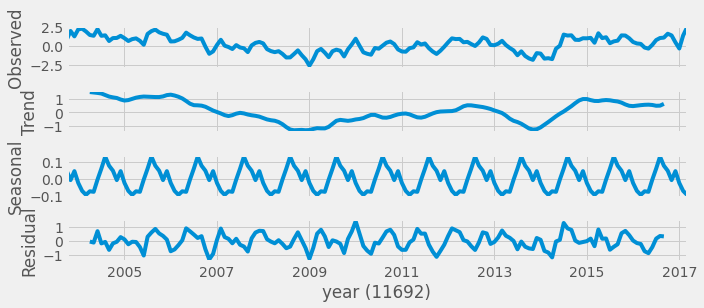

In [41]:
plot_decomposition(sel_df, zip_)

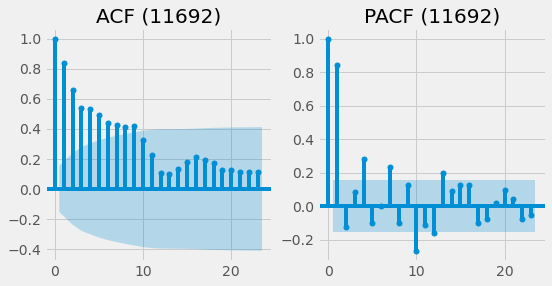

In [42]:
def_acf_pacf(sel_df, zip_)

Removing trend by differencing

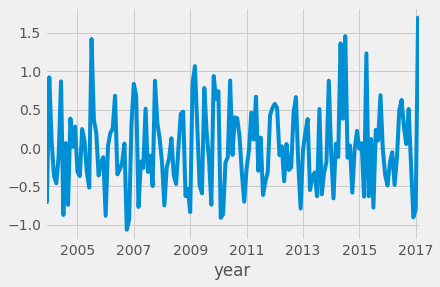

In [43]:
plot_basic(sel_df.diff(1)[1:])

In [44]:
run_dickyey_fuller(sel_df.diff(1)[1:], zip_)

Null Rejected (p = 0.0). 11692 time series is stationary


#### SARIMA
First let's find the best parameters that yield the lowest AIC.

In [45]:
pdq, SPDQ = find_sarima_param(sel_df)

pdq: (1, 0, 1), PDQS: (1, 0, 1, 12) - AIC: 175.0


In [46]:
sarima = SARIMAX(sel_df, order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
model = sarima.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              11692   No. Observations:                  162
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 -82.499
Date:                            Tue, 06 Oct 2020   AIC                            174.998
Time:                                    22:07:51   BIC                            189.984
Sample:                                10-01-2003   HQIC                           181.087
                                     - 03-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9327      0.034     27.121      0.000       0.865       1.000
ma.L1          0.1257      0.076   

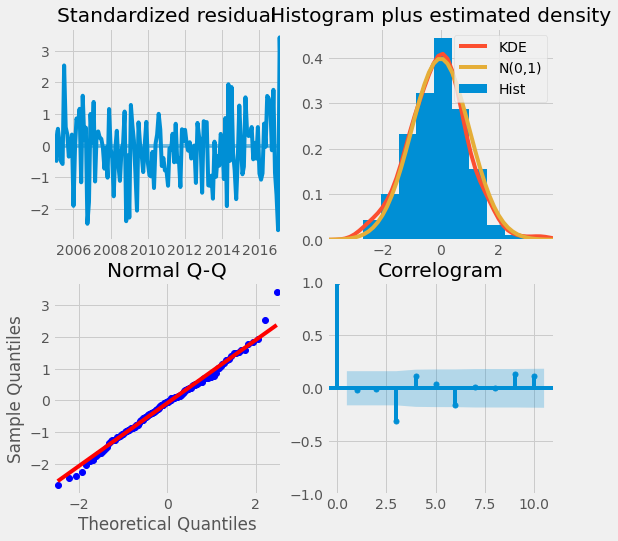

In [47]:
model.plot_diagnostics(figsize = (8, 8))
plt.show()

In [48]:
zip_

'11692'

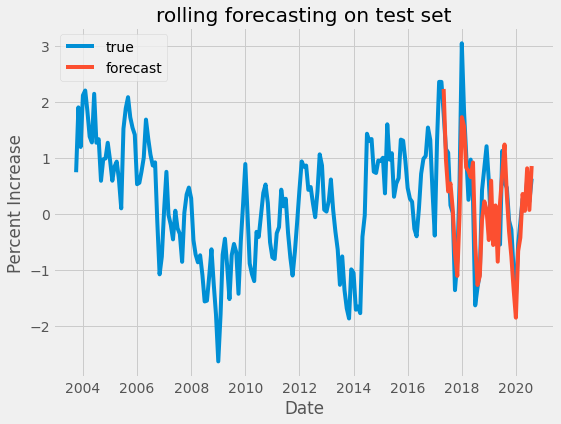

In [49]:
rmse_11692 = test_RMSE(df[zip_], pdq, SPDQ)

### zipcode [3]
---

In [50]:
zip_ = select_zipcode[3]

In [51]:
sel_df = trdf[zip_]

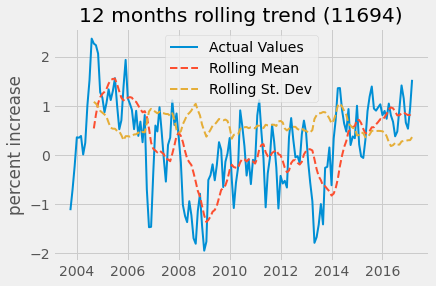

In [52]:
plot_moving_avg(sel_df, 12, zip_)

In [53]:
run_dickyey_fuller(sel_df, zip_)

Failed to reject the null (p = 0.5557). 11694 time series is not stationary


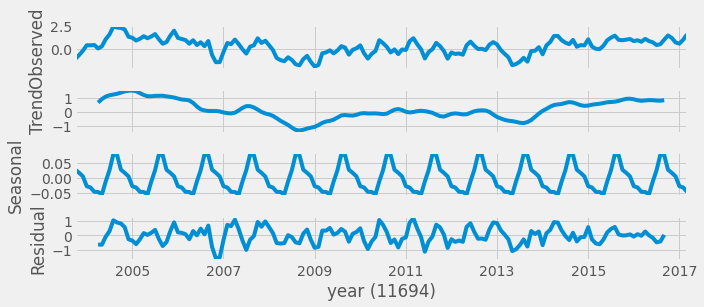

In [54]:
plot_decomposition(sel_df, zip_)

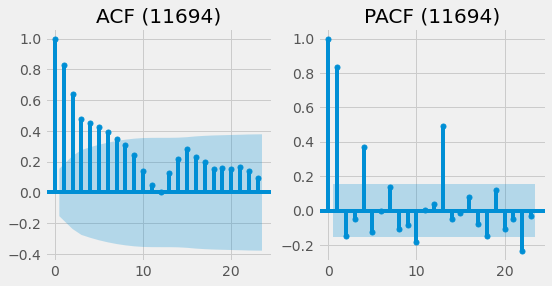

In [55]:
def_acf_pacf(sel_df, zip_)

Removing trend by differencing

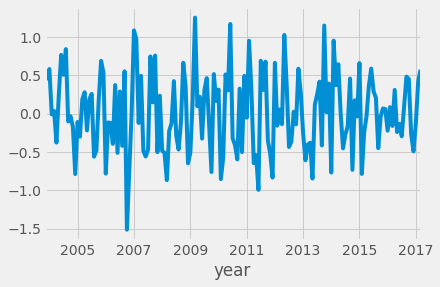

In [56]:
plot_basic(sel_df.diff(1)[1:])

In [57]:
run_dickyey_fuller(sel_df.diff(1)[1:], zip_)

Null Rejected (p = 0.0). 11694 time series is stationary


#### SARIMA
First let's find the best parameters that yield the lowest AIC.

In [58]:
pdq, SPDQ = find_sarima_param(sel_df)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq: (1, 0, 0), PDQS: (1, 0, 1, 12) - AIC: 118.4


In [59]:
sarima = SARIMAX(sel_df, order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
model = sarima.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              11694   No. Observations:                  162
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 12)   Log Likelihood                 -55.200
Date:                            Tue, 06 Oct 2020   AIC                            118.400
Time:                                    22:08:15   BIC                            130.415
Sample:                                10-01-2003   HQIC                           123.281
                                     - 03-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9442      0.025     37.899      0.000       0.895       0.993
ar.S.L12      -0.2386      0.107   

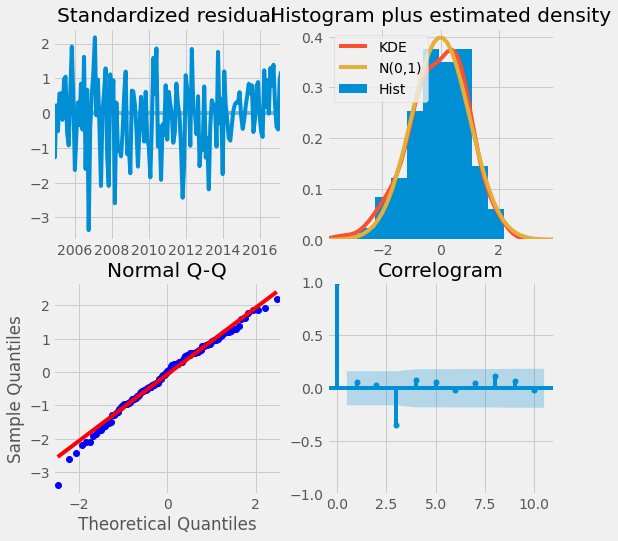

In [60]:
model.plot_diagnostics(figsize = (8, 8))
plt.show()

In [61]:
zip_

'11694'

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


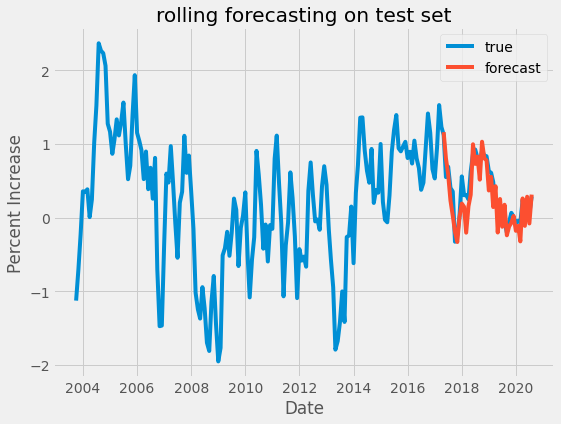

In [62]:
rmse_11694 = test_RMSE(df[zip_], pdq, SPDQ)

### zipcode [4]
---

In [63]:
zip_ = select_zipcode[4]

In [64]:
sel_df = trdf[zip_]

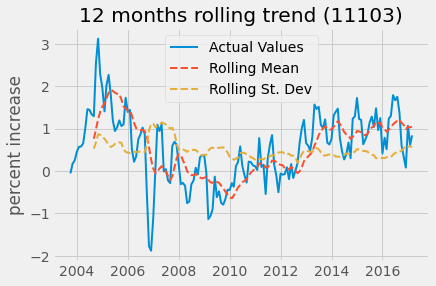

In [65]:
plot_moving_avg(sel_df, 12, zip_)

In [66]:
run_dickyey_fuller(sel_df, zip_)

Failed to reject the null (p = 0.1339). 11103 time series is not stationary


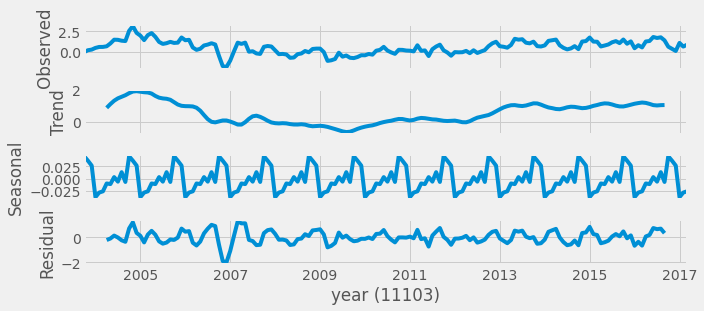

In [67]:
plot_decomposition(sel_df, zip_)

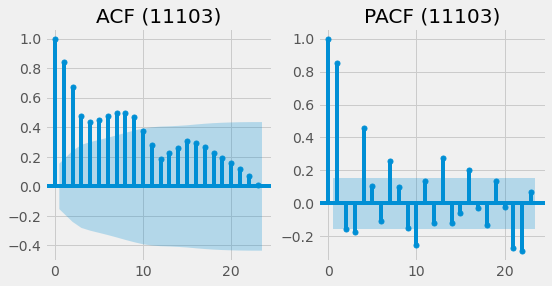

In [68]:
def_acf_pacf(sel_df, zip_)

Removing trend by differencing

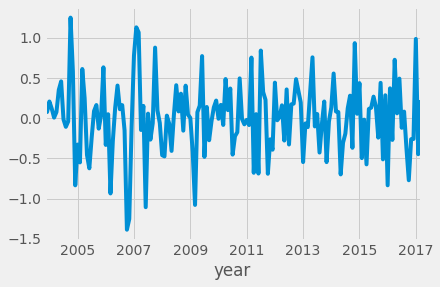

In [69]:
plot_basic(sel_df.diff(1)[1:])

In [70]:
run_dickyey_fuller(sel_df.diff(1)[1:], zip_)

Null Rejected (p = 0.0001). 11103 time series is stationary


#### SARIMA
First let's find the best parameters that yield the lowest AIC.

In [71]:
pdq, SPDQ = find_sarima_param(sel_df)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq: (0, 1, 1), PDQS: (1, 0, 1, 12) - AIC: 95.9


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [72]:
sarima = SARIMAX(sel_df, order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
model = sarima.fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              11103   No. Observations:                  162
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 -43.948
Date:                            Tue, 06 Oct 2020   AIC                             95.895
Time:                                    22:08:35   BIC                            107.857
Sample:                                10-01-2003   HQIC                           100.755
                                     - 03-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1085      0.073      1.478      0.139      -0.035       0.252
ar.S.L12      -0.2031      0.073   

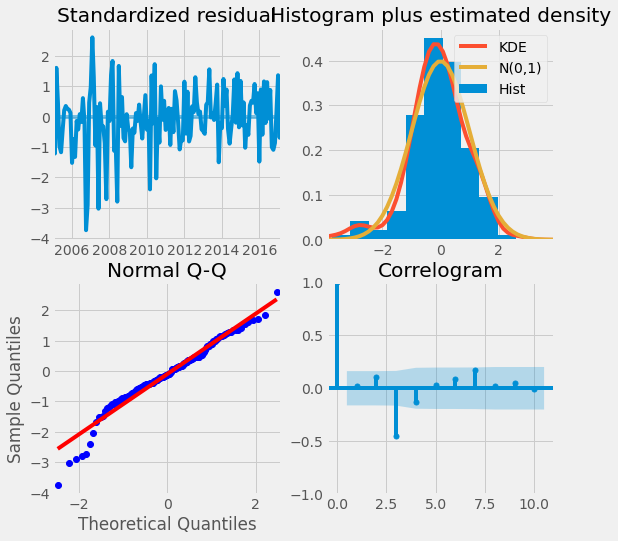

In [73]:
model.plot_diagnostics(figsize = (8, 8))
plt.show()

In [74]:
zip_

'11103'

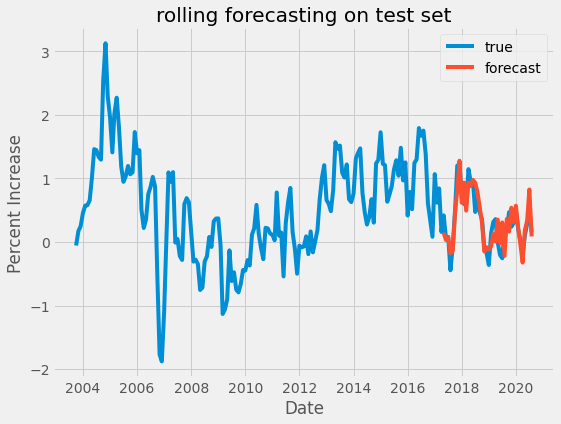

In [75]:
rmse_11103 = test_RMSE(df[zip_], pdq, SPDQ)

## SARIMA Total RMSE

In [76]:
sarima_total_rmse = rmse_11101 + rmse_11103 + rmse_11692 + rmse_11693 + rmse_11694

In [77]:
sarima_total_rmse

1.7204182180710808

# Facebook Prophet
Now I will run the similar step using Facebook Prophet.

In [119]:
df = df.reset_index()

In [168]:
# renaming to FB Prophet convention
zip_ = select_zipcode[0]
sel_df = pd.DataFrame(df[['index', zip_]])

In [175]:
zip_

'11101'

In [199]:
def fb_prophet_forecast(df0, term = 40, show = True):
    df = df0.copy()
    df.columns = ['ds', 'y']
    train = df[:-term]
    test = df[-term:]
    model = Prophet(yearly_seasonality = True, interval_width = 0.95)
    model.add_country_holidays(country_name = 'US')
    model.fit(train)
    future_terms = model.make_future_dataframe(periods = term, freq = 'MS')
    forecast = model.predict(future_terms)
    if show:
        model.plot(forecast, xlabel = 'date', 
                   ylabel = 'percent increase', figsize = (8, 6))
        plt.show()
        model.plot_components(forecast, figsize = (8, 6))
        plt.show()
    return RMSE(test['y'], list(forecast['yhat'][-term:]))

In [201]:
rmse_11101 # 0.6173878217249876


0.5963023790873738

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


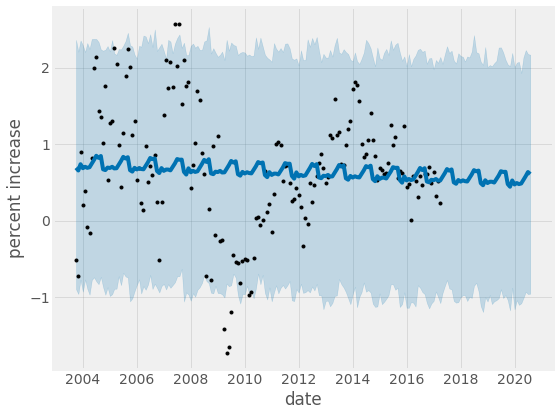

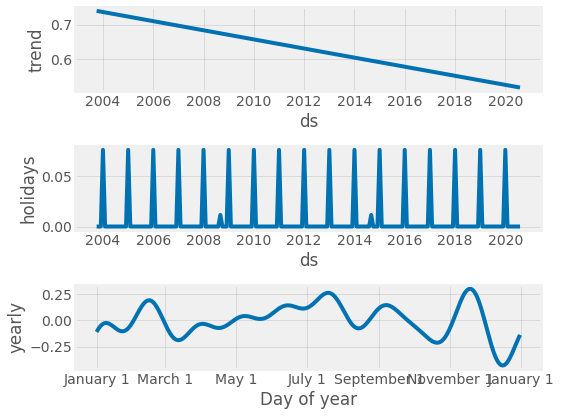

In [200]:
rmse_11101 = fb_prophet_forecast(sel_df)